In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

In [85]:
# set graphical parameters
% matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 90
sns.set_context('notebook', font_scale=1.05)
sns.set_style('white')

pal = ['#066b2b', '#0a3e78', '#ae1626','#444745','#55a15a', '#5588a1', 'indianred']

In [86]:
wd = 'data\\' #path if you download the data folder and save in the same location with the notebook

#wd = 'C:\\Users\\Aaron\\Dropbox\\MSPA\\Pred498\\Group Project\\'

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

train = pd.read_csv(wd + 'train.csv', parse_dates=[2], date_parser=dateparse, index_col='Date')
store = pd.read_csv(wd + 'store.csv')
train.head()

C:\Users\Aaron\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [87]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

In [88]:
train.dtypes

Store             int64
DayOfWeek         int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
Year              int64
Month             int64
Day               int64
WeekOfYear        int64
dtype: object

In [89]:
train.index # in reverse order (newest data points first)

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [90]:
train.shape

(1017209, 12)

In [91]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### Analysis of Sales (Target Variable)

* How do sales vary (what does the distribution of sales look like and how is it impacted by the various explanatory features?)

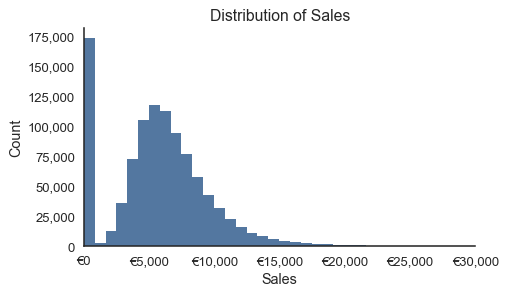

In [92]:
fig, ax = plt.subplots(figsize = (5, 3))

ax.hist(train['Sales'], alpha = .7, bins=50, color = pal[1])
ax.set_title('Distribution of Sales')
ax.set_ylabel('Count', fontname = 'Arial')
ax.set_xlabel('Sales', fontname = 'Arial')
ax.set_xlim(0, 30000)

x_vals = ax.get_xticks()
ax.set_xticklabels(['€{:,.0f}'.format(x) for x in x_vals], fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

What proportion of the time are sales 0?

In [93]:
pd.concat([train['Open'].value_counts(),
           train['Open'].value_counts(normalize = True)], 
          axis = 1)

,Open,Open
1,844392,0.830107
0,172817,0.169893


For nearly 17% of the data in the training set, the stores are closed and sales are equal to 0. We don't need to generate forecasts for these days since they should always be 0.

#### Which days are stores closed?

The majority of closures are on the 7th day of the week (sunday?). Are these particular stores?

In [94]:
train[train['Open'] == 0]['DayOfWeek'].value_counts()

7    141137
4     11201
5      7205
1      7170
3      3729
2      1703
6       672
Name: DayOfWeek, dtype: int64

In [95]:
train[train['Open'] == 0].groupby(['StateHoliday', 'SchoolHoliday'])['Open'].aggregate('count').unstack()

SchoolHoliday,0,1
StateHoliday,,
0,18128.0,804.0
0,121482.0,2263.0
a,14465.0,5101.0
b,478.0,6067.0
c,NaN,4029.0


### Sales by Store, Customer

In [96]:
train['Sales_Per_Customer'] = train['Sales'] / train['Customers']
train['Sales_Per_Customer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: Sales_Per_Customer, dtype: float64

The mean sales per customer is ~$9.50

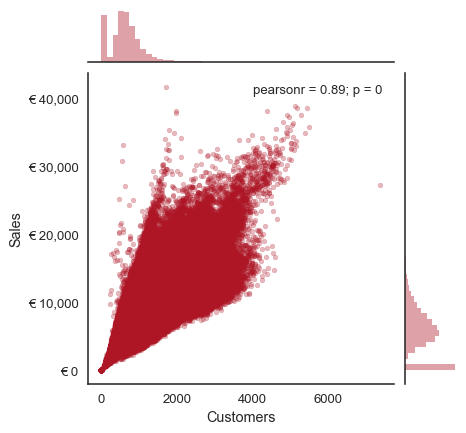

In [97]:
g = sns.jointplot(x = 'Customers', y = 'Sales', data = train, color = pal[2], alpha = 0.3, joint_kws={'s': 15}, size = 5)
y_vals = g.ax_joint.get_yticks()
g.ax_joint.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals]);


* Check the variability around customers, sales per customer at the store level.

### Impact of Promotions, Holidays on Sales

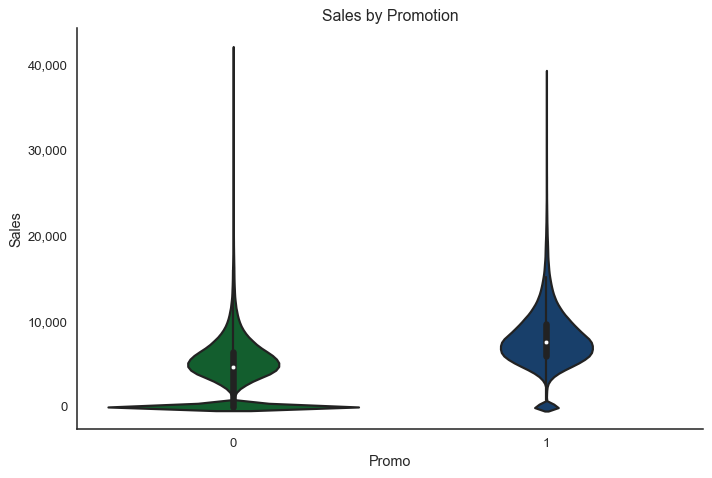

In [98]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'Promo', y = 'Sales', data = train, palette = pal)
ax.set_title('Sales by Promotion')
ax.set_xlabel('Promo')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

How does sales per customer change during promotional periods?

In [99]:
train.groupby('Promo')['Sales_Per_Customer'].median()

Promo
0    8.741597
1    9.956947
Name: Sales_Per_Customer, dtype: float64

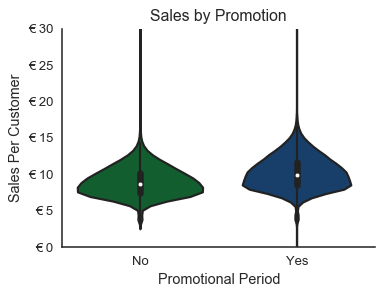

In [100]:
fig, ax = plt.subplots(figsize = (4, 3))
ax = sns.violinplot(x = 'Promo', y = 'Sales_Per_Customer', data = train, palette=pal, alpha = 0.8)
ax.set_title('Sales by Promotion', fontname = 'Arial')
ax.set_xlabel('Promotional Period', fontname = 'Arial')
ax.set_ylabel('Sales Per Customer', fontname = 'Arial')

ax.set_ylim(0, 30)

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

x_vals = ax.get_xticks()
ax.set_xticklabels(['No', 'Yes'], fontname = 'Arial')

sns.despine();

As expected, generally higher sales during promotional periods.

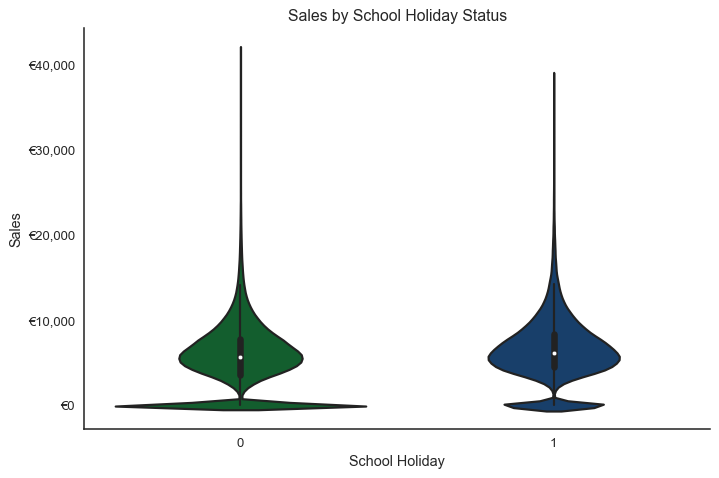

In [101]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'SchoolHoliday', y = 'Sales', data = train, palette = pal)
ax.set_title('Sales by School Holiday Status')
ax.set_xlabel('School Holiday')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

In [102]:
train['StateHoliday'].value_counts().index

Index(['0', 0, 'a', 'b', 'c'], dtype='object')

In [103]:
# fix zeros on StateHoliday
def zero_str(var):
    if var == 0:
        return('0')
    else:
        return(var)
    
train['StateHoliday'] = train['StateHoliday'].apply(lambda x: zero_str(x))

train['StateHoliday'].value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

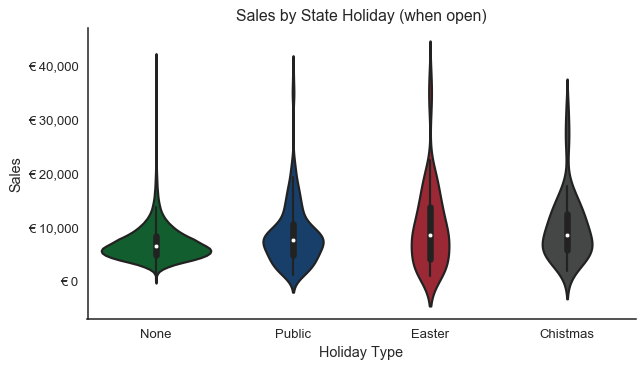

In [104]:
fig, ax = plt.subplots(figsize = (7, 4))
ax = sns.violinplot(x = 'StateHoliday', y = 'Sales', data = train[train['Open']==1], palette = pal)
ax.set_title('Sales by State Holiday (when open)', fontname = 'Arial')
ax.set_xlabel('Holiday Type', fontname = 'Arial')
ax.set_ylabel('Sales', fontname = 'Arial')

hol_list = ['None', 'Public', 'Easter', 'Chistmas']

x_vals = ax.get_xticks()
ax.set_xticks(x_vals)
ax.set_xticklabels(hol_list, fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

sns.despine();

In [105]:
sns.set_context('notebook', font_scale=1.05)

a = public holiday<br></br>
b = Easter holiday<br></br>
c = Christmas<br></br>
0 = None<br></br>


In [106]:
train[train['Open'] == 1].groupby('StateHoliday')['Sales'].median()

StateHoliday
0    6368
a    7556
b    8423
c    8397
Name: Sales, dtype: int64

##### Do people spend more on holidays?

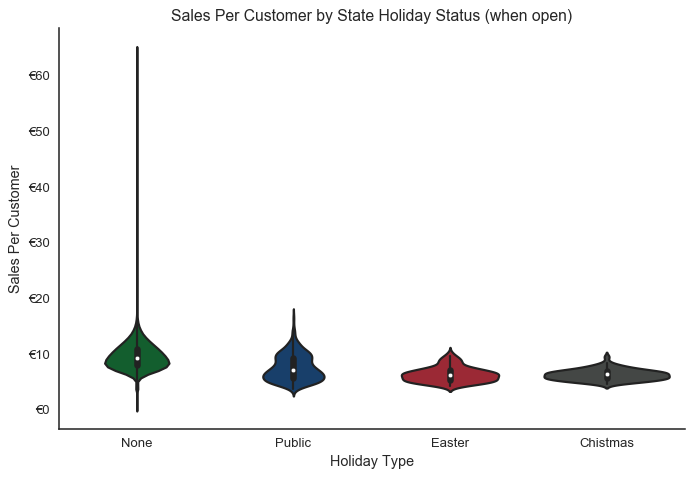

In [107]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StateHoliday', y = 'Sales_Per_Customer', data = train[train['Open']==1],
                   palette = pal)
ax.set_title('Sales Per Customer by State Holiday Status (when open)')
ax.set_xlabel('Holiday Type')
ax.set_ylabel('Sales Per Customer')

hol_list = ['None', 'Public', 'Easter', 'Chistmas']

x_vals = ax.get_xticks()
ax.set_xticks(x_vals)
ax.set_xticklabels(hol_list)

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])

sns.despine();

### Sales by Date of Week

In [108]:
train[train['Open']==1].groupby('DayOfWeek')['Sales'].median()

DayOfWeek
1    7539
2    6502
3    6210
4    6246
5    6580
6    5425
7    6876
Name: Sales, dtype: int64

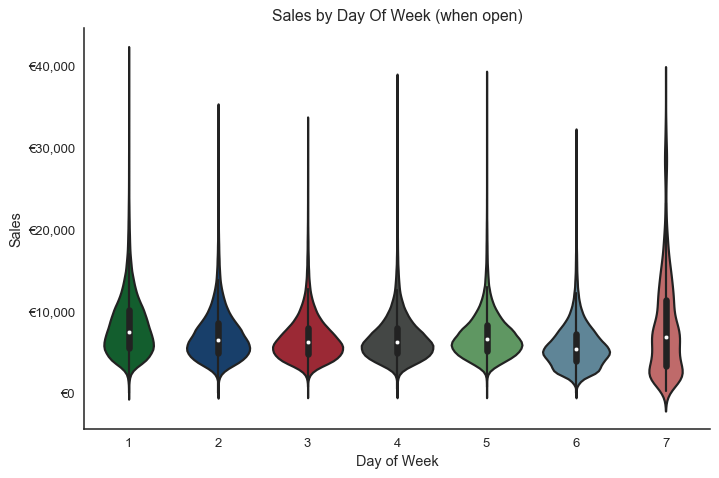

In [109]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'DayOfWeek', y = 'Sales', data = train[train['Open']==1], palette = pal)
ax.set_title('Sales by Day Of Week (when open)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€{:,.0f}'.format(y) for y in y_vals])
sns.despine();

### Overall Sales - Downsampling

Group by date and analyze total sales over time

In [110]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Sales_Per_Customer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [111]:
train_grp = pd.DataFrame(train.groupby('Date')['Sales', 'Customers'].sum())
train_ds = pd.DataFrame(train_grp.resample('W').sum())
train_ds['SalesPerCustomer'] = train_ds.Sales / train_ds.Customers
train_ds['Sales_4RA'] = pd.rolling_mean(train_ds.Sales, window = 4, center=True)
train_ds['Customers_4RA'] = pd.rolling_mean(train_ds.Customers, window = 4, center = True)
train_ds['SpC_4RA'] = pd.rolling_mean(train_ds.SalesPerCustomer, window = 4, center = True)
train_ds.head()

C:\Users\Aaron\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=True).mean()
C:\Users\Aaron\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=True).mean()
C:\Users\Aaron\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=True).mean()


,Sales,Customers,SalesPerCustomer,Sales_4RA,Customers_4RA,SpC_4RA
Date,,,,,,
2013-01-06,26129335,3110602,8.400089,NaN,NaN,NaN
2013-01-13,49275222,5226350,9.428228,NaN,NaN,NaN
2013-01-20,34377765,4205743,8.174005,38955622.75,4367882.00,8.835828
2013-01-27,46040169,4928833,9.340988,42039796.25,4717144.00,8.869180
2013-02-03,38466029,4507650,8.533499,41971561.50,4717216.25,8.855995


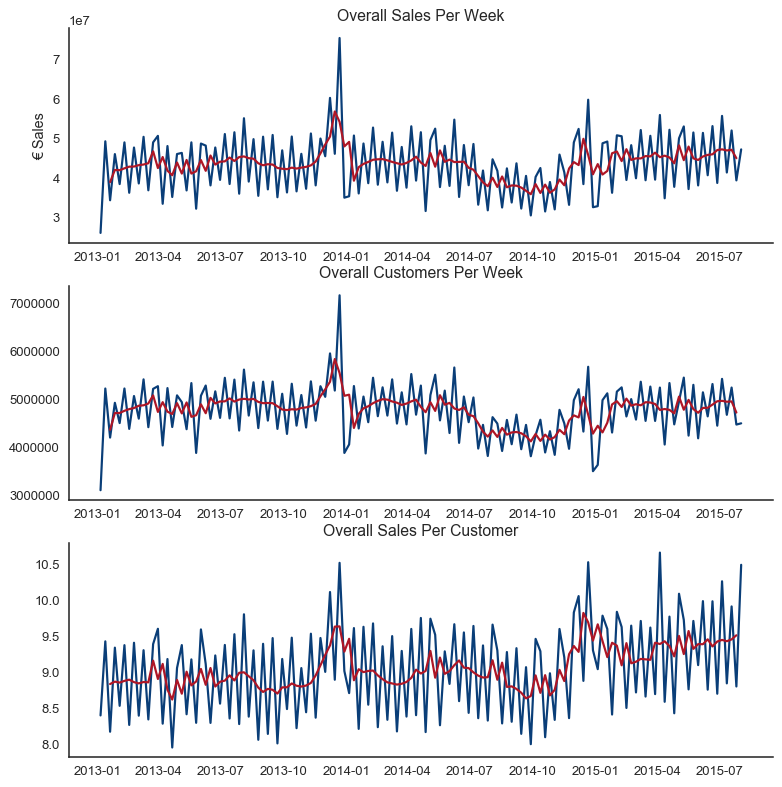

In [112]:
fig, ax = plt.subplots(3, 1, figsize = (9, 10))
ax11, ax21, ax31 = ax.ravel()

ax11.plot(train_ds['Sales'], color = pal[1])
ax11.plot(train_ds['Sales_4RA'], color = pal[2])
ax11.set_title('Overall Sales Per Week' ,fontname = 'Arial')
ax11.set_ylabel('€ Sales', fontname = 'Arial')

ax21.plot(train_ds['Customers'], color = pal[1])
ax21.plot(train_ds['Customers_4RA'], color = pal[2])
ax21.set_title('Overall Customers Per Week')


ax31.plot(train_ds['SalesPerCustomer'], color = pal[1])
ax31.plot(train_ds['SpC_4RA'], color = pal[2])
ax31.set_title('Overall Sales Per Customer')
sns.despine();


### Store Data

In [113]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [114]:
store.shape

(1115, 10)

In [115]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Join Train and Store data

In [116]:
train_idx = train.reset_index()

In [117]:
merged_data = pd.merge(train_idx, store, how = 'inner', on = 'Store')
merged_data.index = merged_data.Date
merged_data = merged_data.iloc[:,1:]

# extract date components
merged_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Sales_Per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [118]:
merged_data.shape

(1017209, 22)

#### Spot check the data:

In [119]:
train[train.Store == 1].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Sales_Per_Customer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588


In [120]:
merged_data[merged_data.Store == 1].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,Sales_Per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


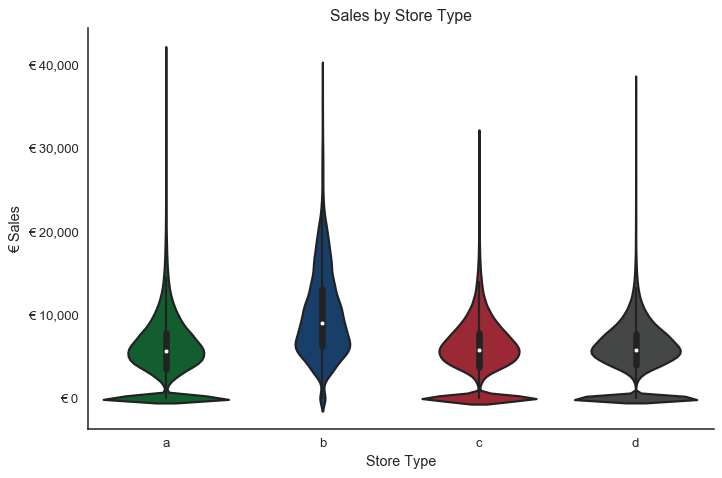

In [121]:
fig, ax = plt.subplots()

sns.violinplot(data = merged_data, 
               x = 'StoreType', 
               y = 'Sales',
               order = ['a', 'b', 'c', 'd'],
              palette = pal,
              ax = ax)

ax.set_title('Sales by Store Type')
ax.set_xlabel('Store Type')
ax.set_ylabel('€ Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])
sns.despine();

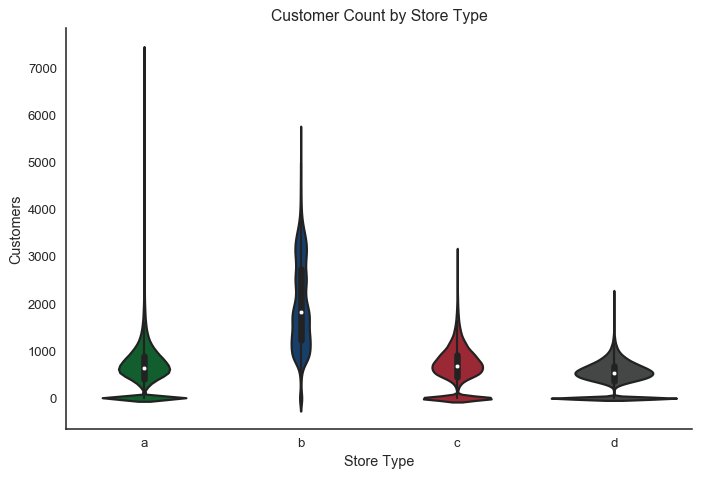

In [129]:
fig, ax = plt.subplots()
ax = sns.violinplot(x = 'StoreType', y = 'Customers',order= ["a","b","c","d"], data = merged_data,palette = pal)
ax.set_title('Customer Count by Store Type')
ax.set_xlabel('Store Type')
ax.set_ylabel('Customers')

y_vals = ax.get_yticks()
#ax.set_yticklabels(['${:,.0f}'.format(y) for y in y_vals])

sns.despine();

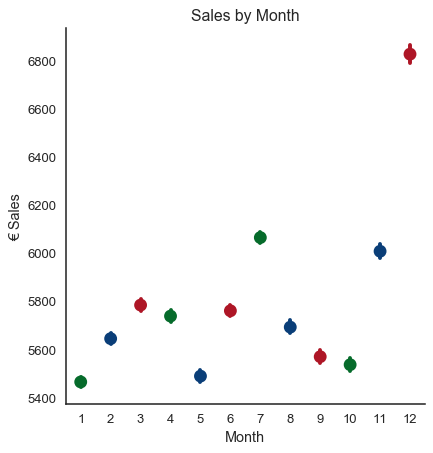

In [122]:
g = sns.factorplot( x = 'Month', 
                y = 'Sales',
                  data = merged_data,
                  palette = pal[0:3],
                  size = 5)

g.set_xlabels('Month')
g.set_ylabels('€ Sales')
plt.title('Sales by Month')
# y_vals = g.ax_factor.get_yticks()
# g.ax_factor.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])
sns.despine();

In [123]:
merged_data.groupby('Month')['Sales'].mean()

Month
1     5465.395529
2     5645.253150
3     5784.578871
4     5738.866916
5     5489.639973
6     5760.964375
7     6064.915711
8     5693.016554
9     5570.246033
10    5537.037419
11    6008.111821
12    6826.611377
Name: Sales, dtype: float64

Sales per customer appears to vary quite a bit depending upon the month. What might explain some of this variability?

### Impact of Promotions

* Are sales higher during promotional periods based on store type?
* Do Promos attract more customers?
* Do customers spend more during promos?

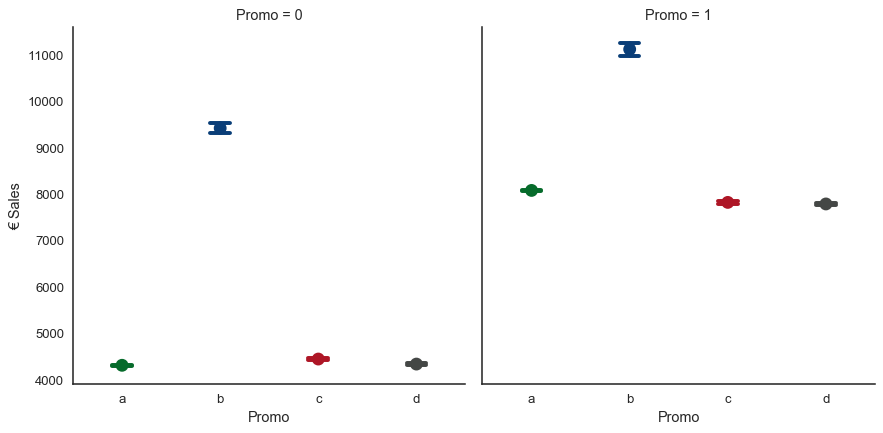

In [130]:
g = sns.factorplot(x = 'StoreType', 
                  y = 'Sales', 
                   col = 'Promo',
                  data = merged_data,
                  palette = pal,
                  size = 5,
                  capsize = .2,
                  order = ['a', 'b', 'c' ,'d'])

g.set_xlabels('Promo')
g.set_ylabels('€ Sales');

^ think about displaying this graph in a different way if going to include in report

Sales are higher during promotional periods across the board. Is this because they draw in more customers or because customers tend to spend more?

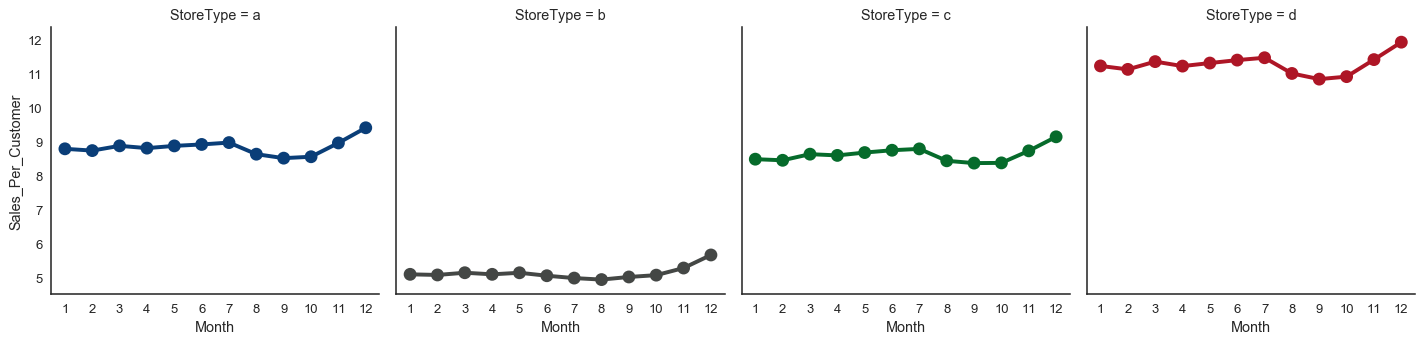

In [139]:
sns.factorplot(data = merged_data, 
               x = 'Month', 
               y = "Sales_Per_Customer", 
               col = 'StoreType', 
               palette = pal,
               hue = 'StoreType',
              col_order = ['a', 'b', 'c', 'd']);

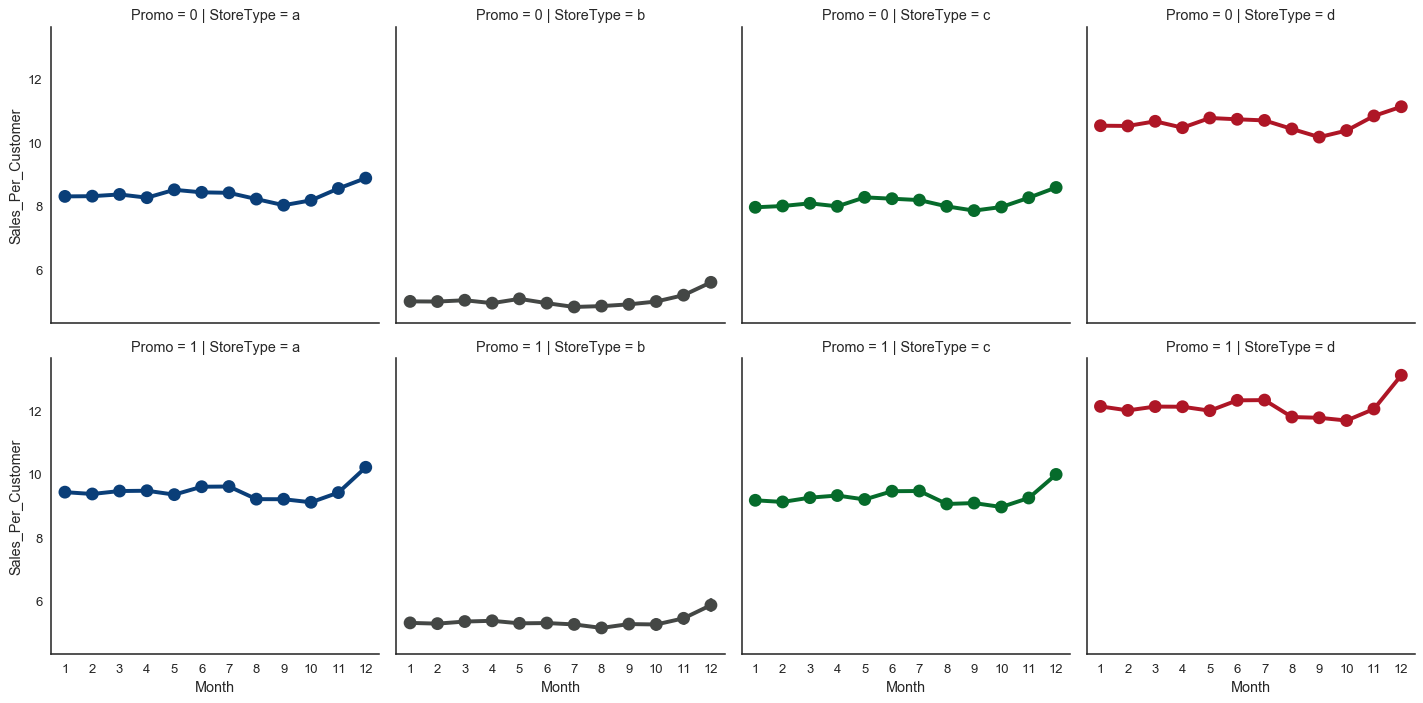

In [147]:
sns.factorplot(data = merged_data,
               x = 'Month', 
               y = "Sales_Per_Customer", 
               col = 'StoreType', 
               hue = 'StoreType',
               row = 'Promo',
              palette = pal,
              col_order = ['a', 'b', 'c', 'd']); 

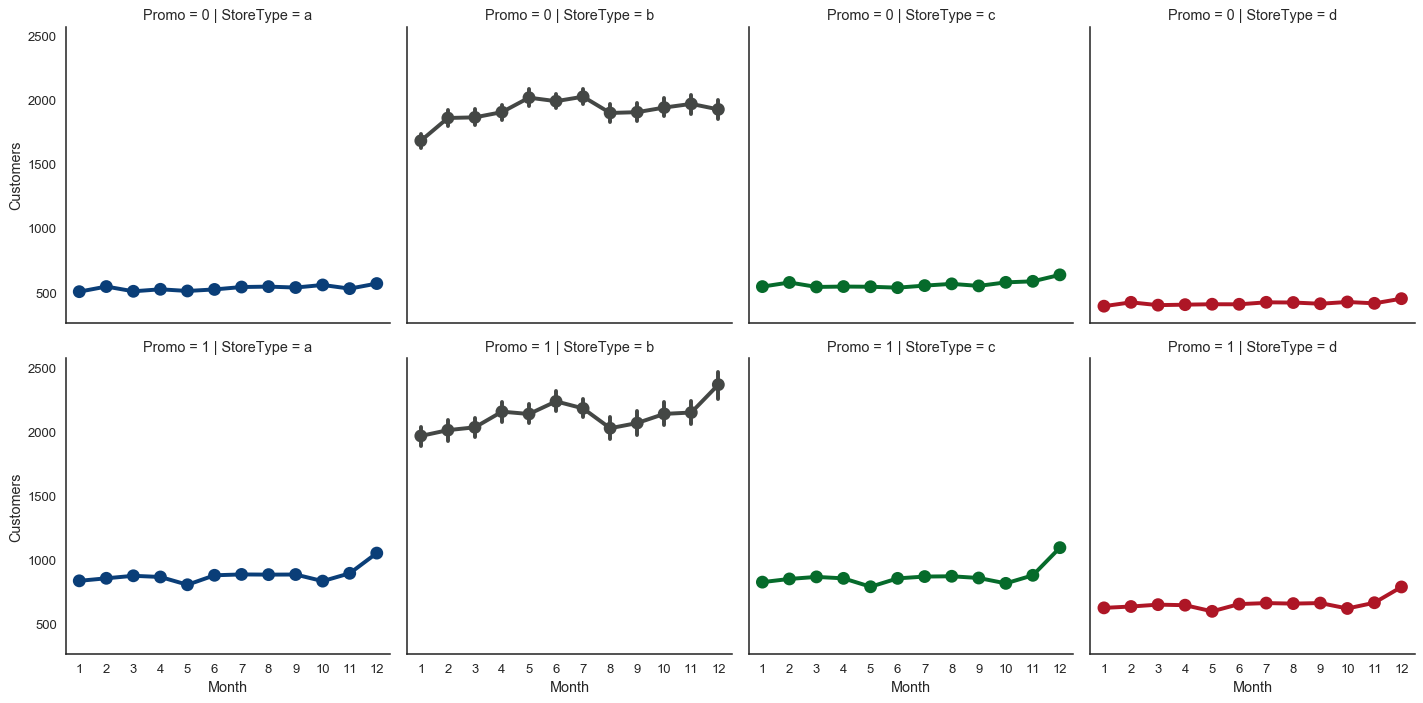

In [148]:
sns.factorplot(data = merged_data,
               x = 'Month', 
               y = "Customers", 
               col = 'StoreType', 
               hue = 'StoreType',
               row = 'Promo',
              palette = pal,
              col_order = ['a', 'b', 'c', 'd']); 

Promos appear to attract more customers for each store type and customers also appear to spend more during promotional periods within each store type.

### Competition Analysis

In [154]:
# Assume that having no competition listed means no direct competition?
merged_data['CompetitionDistance'].isnull().sum()

2642

In [156]:
def competition(var):
    if var > 0:
        return(1)
    else:
        return(0)
    
merged_data['Ind_Competition'] = merged_data['CompetitionDistance'].apply(lambda x: competition(x))
merged_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Ind_Competition
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1
2015-07-30,1,4,5020,546,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1
2015-07-29,1,3,4782,523,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1
2015-07-28,1,2,5011,560,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1
2015-07-27,1,1,6102,612,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1


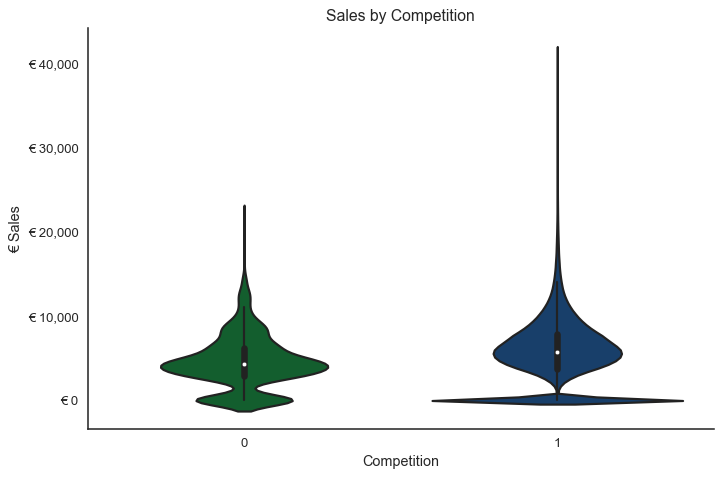

In [158]:
fig, ax = plt.subplots()

sns.violinplot(data = merged_data, 
               x = 'Ind_Competition', 
               y = 'Sales',
              palette = pal,
              ax = ax)

ax.set_title('Sales by Competition')
ax.set_xlabel('Competition')
ax.set_ylabel('€ Sales')

y_vals = ax.get_yticks()
ax.set_yticklabels(['€ {:,.0f}'.format(y) for y in y_vals])
sns.despine();

## Feature Engineering Ideas

* Length of time competition in Business
* Interaction between Competition length of time in Business and Competition Distance
* Length of time Promo2

